In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
import io
import os
import re
import shutil
import string
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.backend import dtype
from tensorflow.python.keras.layers.merge import concatenate

import tensorflow_hub as hub

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from tensorflow.keras import layers, Model,losses

import numpy as np

import matplotlib.pyplot as plt

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [4]:
df = pd.read_csv('gdrive/MyDrive/datasets/amazon_reviews.txt', index_col=False, delimiter="\t")
# features = ["REVIEW_TEXT", "RATING", "LABEL", "VERIFIED_PURCHASE"]
features = ["REVIEW_TEXT","LABEL"]
df = df[features]

In [23]:
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].replace('N', 0)
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].replace('Y', 1)

In [5]:
print(df.shape)
df.head()

(21000, 2)


,REVIEW_TEXT,LABEL
0,"When least you think so, this product will sav...",0
1,Lithium batteries are something new introduced...,0
2,I purchased this swing for my baby. She is 6 m...,0
3,I was looking for an inexpensive desk calcolat...,0
4,I only use it twice a week and the results are...,0


In [8]:
# # This shel was executed in order to create the required files "train_valid_amazon_reviews.txt" and "test_amazon_reviews.txt"
# # It it NOT NEEDED TO EXECUTED AGAIN since we have already the files 

# from sklearn.model_selection import train_test_split

# # Let's say we want to split the data in 80:10:10 for train:valid:test dataset
# train_val_size=0.9

# X = df.copy()

# # In the first step we will split the data in training and remaining dataset
# X_train_val, X_test= train_test_split(X, train_size=train_val_size)

# # # Now since we want the valid and test size to be equal (10% each of overall data). 
# # # we have to define valid_size=0.5 (that is 50% of remaining data)
# # test_size = 0.5
# # X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

# # print(X_train.shape), print(y_train.shape)
# # print(X_valid.shape), print(y_valid.shape)
# # print(X_test.shape), print(y_test.shape)

# X_test.to_csv(r'gdrive/MyDrive/datasets/test_amazon_reviews.txt', header=True, index=None, sep="\t", mode='a')
# X_train_val.to_csv(r'gdrive/MyDrive/datasets/train_valid_amazon_reviews.txt', header=True, index=None, sep="\t", mode='a')

# print(X_train_val.shape)
# print(X_test.shape)

In [5]:
# train_val_df = pd.read_csv('gdrive/MyDrive/datasets/train_valid_amazon_reviews.txt', index_col=False, delimiter="\t")
# test_df = pd.read_csv('gdrive/MyDrive/datasets/test_amazon_reviews.txt', index_col=False, delimiter="\t")

# print(train_val_df.shape), print(test_df.shape)
# print(train_val_df.columns.values)

In [66]:
# !pip install fast_ml

In [67]:
# from fast_ml.model_development import train_valid_test_split

# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'LABEL', train_size=0.8, valid_size=0.1, test_size=0.1)

# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)

(16800, 1)
(16800,)
(2100, 1)
(2100,)
(2100, 1)
(2100,)


(None, None)

In [6]:
# This shel was executed in order to create the required files "train_valid_amazon_reviews.txt" and "test_amazon_reviews.txt"
# It it NOT NEEDED TO EXECUTED AGAIN since we have already the files 

from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_val_size=0.8

X = df.copy()

# In the first step we will split the data in training and remaining dataset
X_train, X_rem= train_test_split(X, train_size=train_val_size)

# # Now since we want the valid and test size to be equal (10% each of overall data). 
# # we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test = train_test_split(X_rem, test_size=0.5)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(16800, 2)
(2100, 2)
(2100, 2)


In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('LABEL')
  ds1 = tf.data.Dataset.from_tensor_slices(dataframe )
  ds2 = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((ds1, ds2))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  # ds = ds.prefetch(batch_size)
  return ds

In [8]:
batch_size = 32
train_ds = df_to_dataset(X_train, batch_size=batch_size)
val_ds = df_to_dataset(X_valid,  batch_size=batch_size)
test_ds = df_to_dataset(X_test, batch_size=batch_size)

In [9]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review [b"I had to return this watch because it didn't give the correct time for my State. I bought this watch for a birthday present for my son. My son was so upset to find out that the watch he picked out over the internet didn't state the actually locations."]
Label 0
Review [b'A stylish way to carry my clothes in while travelling. A great help since it accomodates more than one. Still using it up until now.']
Label 0
Review [b"Perfect for simple windows during the summer or spring. Yes, they;re quite simple and all, there're also some defects on the actual product but I managed to fix them and now they look great on my windows."]
Label 0


In [10]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
  # text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label.numpy())
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor([b"I live in Spokane and have searched every pet store. It's very hard to find a good digging dirt for my Salamander. This was perfect! Great for a pet that loves to dig and hide."], shape=(1,), dtype=string)
Label 1
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   3,  611,   13,    1,    4,   20, 2432,  175, 1207,  351,   28,
          25,  208,    6,  164,    5,   33, 5850, 1996,   11,   12,    1,
           9,   18,  107,   27,   11,    5, 1207,   14,  262,    6, 3574,
           4, 2556,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [15]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  user
 313 --->  review
Vocabulary size: 10000


In [16]:
train_ds_vec = train_ds.map(vectorize_text)
val_ds_vec = val_ds.map(vectorize_text)
test_ds_vec = test_ds.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_vec = train_ds_vec.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_vec = val_ds_vec.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_vec = test_ds_vec.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
embedding_dim = 16

In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [25]:
epochs = 10
history = model.fit(
    train_ds_vec,
    validation_data=val_ds_vec,
    epochs=epochs)

Epoch 1/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3474 - binary_accuracy: 0.8456 - val_loss: 0.8446 - val_binary_accuracy: 0.6186
Epoch 2/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3429 - binary_accuracy: 0.8511 - val_loss: 0.8543 - val_binary_accuracy: 0.6157
Epoch 3/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3421 - binary_accuracy: 0.8524 - val_loss: 0.8627 - val_binary_accuracy: 0.6190
Epoch 4/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3381 - binary_accuracy: 0.8514 - val_loss: 0.8730 - val_binary_accuracy: 0.6152
Epoch 5/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3358 - binary_accuracy: 0.8545 - val_loss: 0.8826 - val_binary_accuracy: 0.6114
Epoch 6/10
525/525 [==============================] - 3s 5ms/step - loss: 0.3316 - binary_accuracy: 0.8537 - val_loss: 0.8913 - val_binary_accuracy: 0.6133
Epoch 7/10
525/525 [==============================] - 3s 5ms/ste

In [26]:
loss, accuracy = model.evaluate(val_ds_vec)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

66/66 [==============================] - 0s 2ms/step - loss: 0.9286 - binary_accuracy: 0.6062
Loss:  0.928553581237793
Accuracy:  0.6061905026435852


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

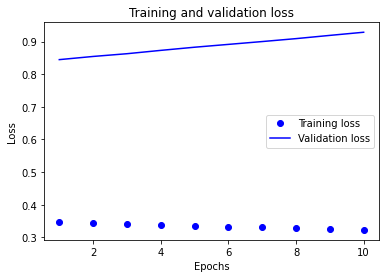

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f2ab4749950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


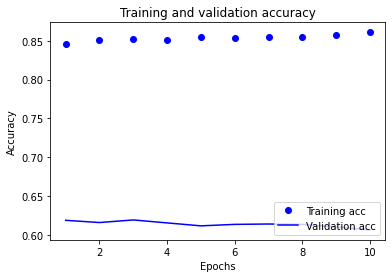

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(val_ds)
print(accuracy)

66/66 [==============================] - 1s 3ms/step - loss: 0.9286 - accuracy: 0.6062
0.6061905026435852
